In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [45]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

train.shape, binaries.shape, categoricals.shape, cont_ordinals.shape

((595212, 59), (595212, 17), (595212, 14), (595212, 26))

In [4]:
# Baseline bulk frequency of Class1
class1_freq = np.sum(target)/len(target)
class1_freq

0.036447517859182946

In [5]:
cont_ordinals.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01',
       'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03'],
      dtype='object')

In [6]:
test = cont_ordinals.loc[:, ['ps_reg_01', 'ps_ind_03']]

In [7]:
test_converted = ps.convertOrdinalFeatures(test, target)

In [8]:
test_converted.head(5)

,ps_reg_01,ps_ind_03
0,5.618879,4.912834
1,6.454873,13.328299
2,4.280513,-0.416073
3,12.750362,-15.617174
4,5.618879,46.084586


Text(0.5,1,'Comparison')

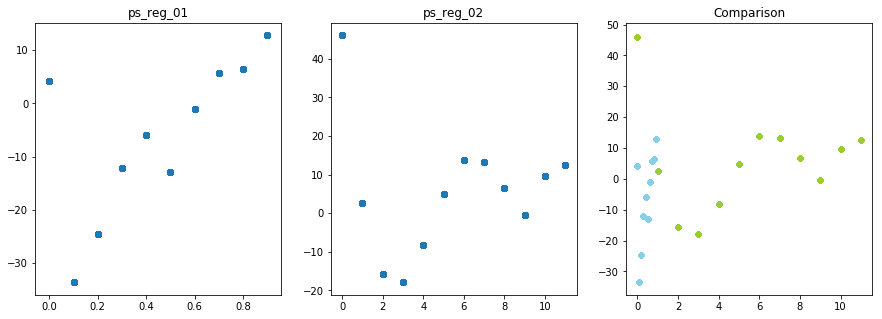

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(test.iloc[:, 0], test_converted.iloc[:, 0])
ax1.set_title('ps_reg_01')
ax2.scatter(test.iloc[:, 1], test_converted.iloc[:, 1])
ax2.set_title('ps_reg_02')
ax3.scatter(test.iloc[:, 0], test_converted.iloc[:, 0], s=20, color='skyblue', alpha=0.3, label='ps_reg_01')
ax3.scatter(test.iloc[:, 1], test_converted.iloc[:, 1], s=20, color='yellowgreen', alpha=0.3, label='ps_reg_02')
ax3.set_title('Comparison')

The graphs look proper in comparison to the KDE plots in nb34 for each feature. Now I can convert the entire feature space in one shot!

## See how long it takes to convert all features (initially done on i5 MacBook Pro)

In [10]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [11]:
%%time
converted = ps.convertOrdinalFeatures(cont_ordinals, target, verbose=True)

Processing ps_calc_01
Processing ps_calc_02
Processing ps_calc_03
Processing ps_calc_04
Processing ps_calc_05
Processing ps_calc_06
Processing ps_calc_07
Processing ps_calc_08
Processing ps_calc_09
Processing ps_calc_10
Processing ps_calc_11
Processing ps_calc_12
Processing ps_calc_13
Processing ps_calc_14
Processing ps_car_11
Processing ps_car_12
Processing ps_car_13
Processing ps_car_14
Processing ps_car_15
Processing ps_ind_01
Processing ps_ind_03
Processing ps_ind_14
Processing ps_ind_15
Processing ps_reg_01
Processing ps_reg_02
Processing ps_reg_03
CPU times: user 3min 23s, sys: 9.32 s, total: 3min 33s
Wall time: 3min 31s


In [12]:
converted.head(10)

,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,...,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03
0,0.033157,0.564815,0.333015,-0.574689,-0.085642,-1.623085,2.068504,-1.074326,-1.853818,-1.431269,...,4.628532,-6.272029,14.167378,0.700330,4.912834,-0.40156,-13.986257,5.618879,-17.470081,-4.559999
1,0.706844,-1.485546,1.335881,1.007697,-0.085642,-0.557878,-2.449961,1.800915,-1.853818,0.068171,...,-19.641741,-5.772784,-18.467825,-7.541982,13.328299,-0.40156,8.373485,6.454873,-1.364078,-1.632219
2,2.028335,0.681293,-1.762433,1.007697,0.415898,-0.557878,2.068504,1.800915,0.739046,0.068171,...,-17.863191,-5.191723,6.825735,11.143586,-0.416073,-0.40156,-15.828742,4.280513,-11.414774,-22.098194
3,0.033157,-0.664123,-1.762433,1.007697,0.465238,-1.143279,2.068504,1.800915,1.197985,-0.792381,...,-24.822424,0.768756,-26.289161,-8.805029,-15.617174,-0.40156,-1.024461,12.750362,-17.470081,-10.900253
4,1.629041,1.263912,-3.269787,1.007697,0.415898,-0.232915,-1.217631,-1.074326,0.739046,-1.732901,...,-23.121694,-6.240336,-26.289161,-8.805029,46.084586,-0.40156,-11.305308,5.618879,14.933445,3.407406
5,0.429577,0.385702,1.096627,-0.574689,-0.085642,1.965574,-0.166591,-1.074326,0.435495,-0.606935,...,4.628532,-3.782870,-4.311472,11.143586,-8.288965,-0.40156,8.861248,12.750362,68.384974,60.718094
6,-1.212545,1.263912,0.566912,1.007697,0.415898,1.965574,2.068504,1.800915,0.435495,1.348883,...,-17.863191,-6.272029,1.184726,0.700330,-17.918591,-0.40156,-1.024461,-1.068751,-17.823418,-9.615246
7,-2.736168,0.564815,-1.762433,-0.149528,0.415898,-1.143279,2.068504,1.904735,-1.853818,-3.096056,...,6.502805,-6.241126,6.825735,11.143586,-8.288965,-0.40156,-15.416979,5.618879,-1.364078,-10.055611
8,1.308819,0.385702,-0.286944,-0.574689,-0.085642,-1.143279,-1.217631,-0.747275,1.197985,-1.351896,...,-6.535568,-3.782870,-9.692951,11.143586,-17.918591,-0.40156,8.861248,12.750362,17.708378,7.253213
9,0.429577,0.385702,1.501779,1.007697,0.415898,1.965574,-0.166591,-0.747275,-1.853818,-1.351896,...,79.416048,-5.493206,14.167378,-7.541982,-15.617174,-0.40156,6.996167,12.750362,31.615542,60.588480


In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA()
X = np.array(converted)
y = np.array(target)

Xpca = pca.fit_transform(X)

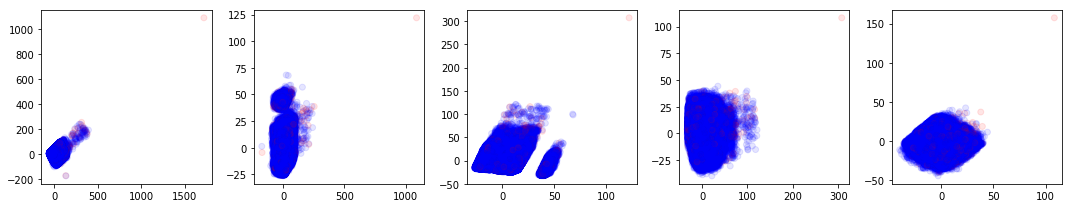

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:, 1], Xpca[:, 2], c=y, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:, 2], Xpca[:, 3], c=y, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:, 3], Xpca[:, 4], c=y, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:, 4], Xpca[:, 5], c=y, cmap=cm.bwr, alpha=0.1)
plt.tight_layout()

In [15]:
new_categoricals = ps.fuseCategoricalFeatures(categoricals)
bincats = pd.concat([binaries, new_categoricals], axis=1)

In [16]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()
    
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [17]:
converted_all = pd.concat([bincat_converted, converted], axis=1)

In [18]:
pca1 = PCA()
X1 = np.array(converted_all)
y = np.array(target)

Xpca1 = pca1.fit_transform(X1)

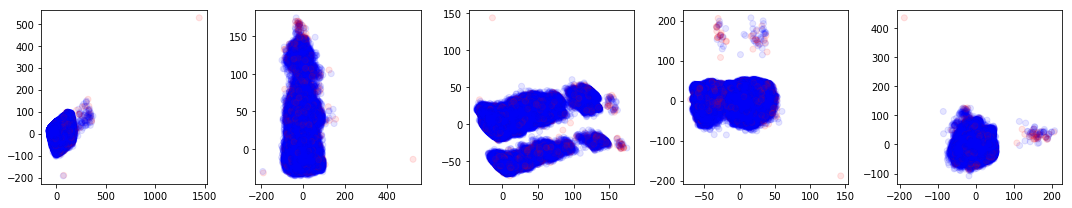

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca1[:, 0], Xpca1[:, 1], c=y, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca1[:, 1], Xpca1[:, 2], c=y, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca1[:, 2], Xpca1[:, 3], c=y, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca1[:, 3], Xpca1[:, 4], c=y, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca1[:, 4], Xpca1[:, 5], c=y, cmap=cm.bwr, alpha=0.1)
plt.tight_layout()

## Quick try on RFC & XGBoost

Gini=0.230+/-0.007, Best=0.241
CPU times: user 11min 11s, sys: 1.09 s, total: 11min 12s
Wall time: 1min 30s


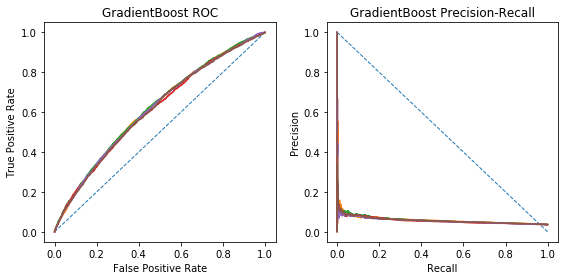

In [21]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca1, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

Gini=0.224+/-0.007, Best=0.237
CPU times: user 24min 45s, sys: 1.63 s, total: 24min 47s
Wall time: 3min 16s


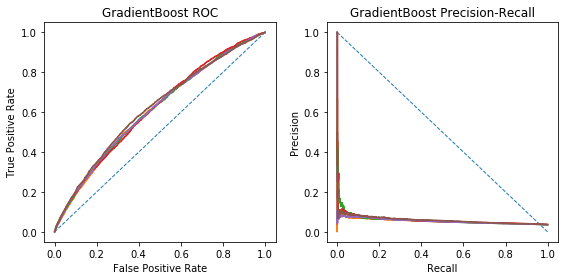

In [33]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca1[:, 1:], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
                       max_depth=11, min_child_weight=4, missing=None, n_estimators=200,
                       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=True, subsample=0.85)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [26]:
clf.feature_importances_

array([ 0.02547771,  0.02224684,  0.02298532,  0.01440044,  0.01610819,
        0.01421582,  0.01430813,  0.01730822,  0.01287732,  0.01306194,
        0.01435429,  0.0136158 ,  0.01283116,  0.01241577,  0.02169297,
        0.01324656,  0.01596972,  0.014862  ,  0.01352349,  0.01883135,
        0.01610819,  0.01421582,  0.01370811,  0.01606203,  0.01356965,
        0.01278501,  0.01564663,  0.0166159 ,  0.01412351,  0.01933906,
        0.02086218,  0.02183144,  0.01670821,  0.02160067,  0.01583126,
        0.01573895,  0.01380042,  0.01763131,  0.0153697 ,  0.01800055,
        0.02275455,  0.02404689,  0.02570848,  0.01463122,  0.02598541,
        0.02335456,  0.01287732,  0.02649312,  0.01440044,  0.0201237 ,
        0.01449275,  0.02723161,  0.02612388,  0.01993907,  0.02293917,
        0.01260039,  0.01241577], dtype=float32)

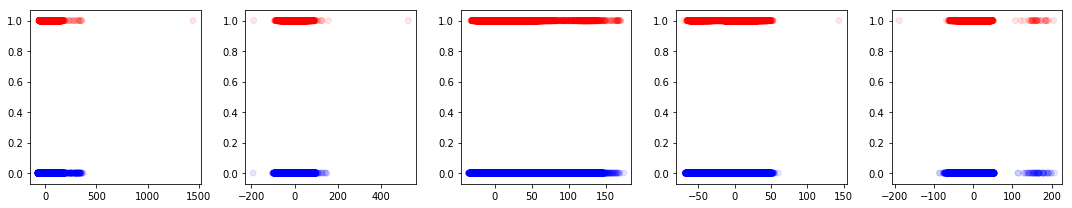

In [27]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca1[:, 0], target, c=y, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca1[:, 1], target, c=y, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca1[:, 2], target, c=y, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca1[:, 3], target, c=y, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca1[:, 4], target, c=y, cmap=cm.bwr, alpha=0.1)
plt.tight_layout()

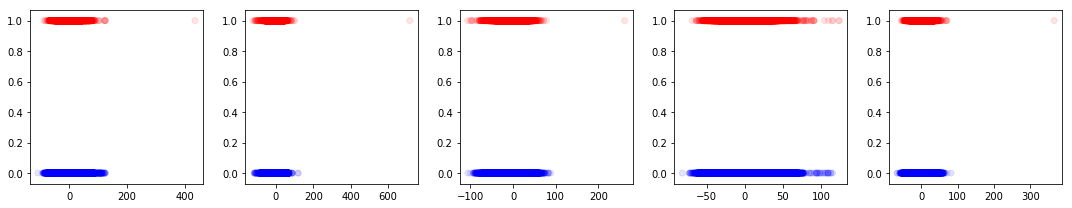

In [29]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca1[:, 5], target, c=y, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca1[:, 6], target, c=y, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca1[:, 7], target, c=y, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca1[:, 8], target, c=y, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca1[:, 9], target, c=y, cmap=cm.bwr, alpha=0.1)
plt.tight_layout()

In [31]:
pca2 = PCA()
X2 = (Xpca1/100) + 1
y = np.array(target)

Xpca2 = pca2.fit_transform(X2)

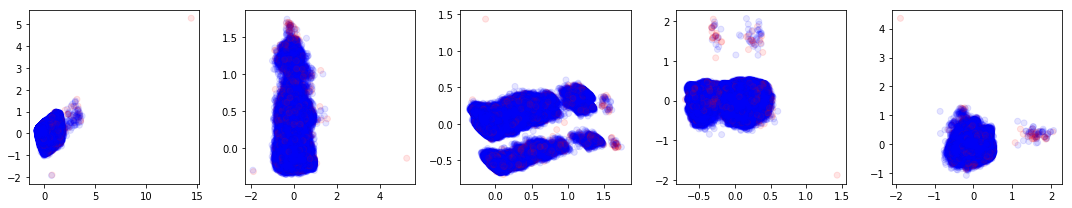

In [32]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca2[:, 0], Xpca2[:, 1], c=y, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca2[:, 1], Xpca2[:, 2], c=y, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca2[:, 2], Xpca2[:, 3], c=y, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca2[:, 3], Xpca2[:, 4], c=y, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca2[:, 4], Xpca2[:, 5], c=y, cmap=cm.bwr, alpha=0.1)
plt.tight_layout()

In [19]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

Gini=0.238+/-0.000, Best=0.238
CPU times: user 31min 55s, sys: 598 ms, total: 31min 55s
Wall time: 4min 8s


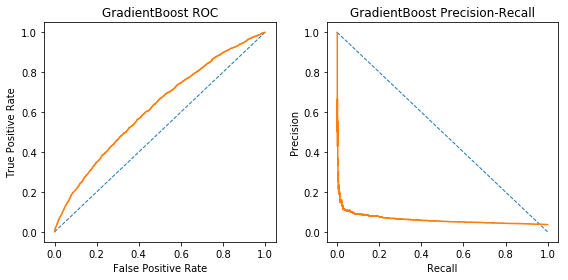

In [34]:
%%time
X3 = np.array(converted_all)
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(1):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = KNeighborsClassifier(n_neighbors=200, weights='distance', n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [43]:
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Gini=0.255+/-0.011, Best=0.272
CPU times: user 2min 42s, sys: 5.33 s, total: 2min 48s
Wall time: 25.6 s


/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


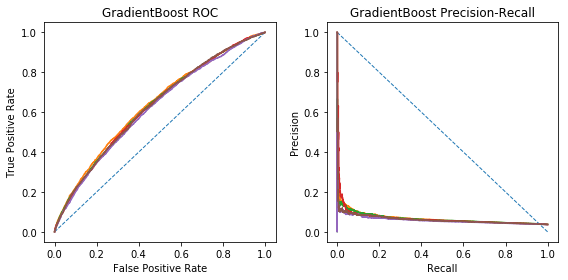

In [58]:
%%time
t = train
X3 = np.array(t.iloc[:, 2:])
y3 = np.array(t.iloc[:, 1])
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca1, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [59]:
from sklearn.linear_model import LogisticRegression

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(self.n_jobs))


Gini=0.262+/-0.000, Best=0.262
CPU times: user 37.4 s, sys: 630 ms, total: 38.1 s
Wall time: 7.73 s


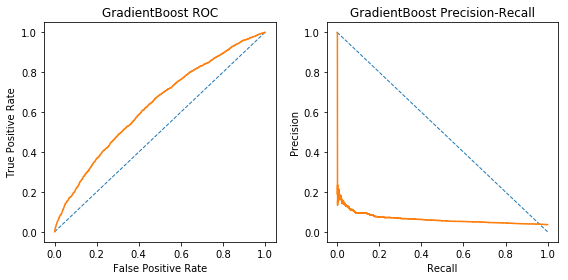

In [61]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(1):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca1, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = LogisticRegression(C=1, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))